<a href="https://colab.research.google.com/github/mppenfold/AIHC5010-Winter-2026/blob/main/20260216_project1_zein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 — Colab Workflow (GitHub + Pre-commit + Submission Validation)

This notebook teaches the standard workflow used throughout the course:

1. Clone your team repo
2. Install dependencies
3. Install **pre-commit** and enable a hook to strip notebook outputs
4. Run this notebook end-to-end
5. Validate `predictions.csv`
6. Commit + push + tag


In [1]:
# (Colab) show python and system info
import sys, platform
print(sys.version)
print(platform.platform())


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Linux-6.6.105+-x86_64-with-glibc2.35


## 1) Clone Repo

Login to your personal Github account, and make a fork of: https://github.com/TLKline/AIHC-5010-Winter-2026

Follow setup directions for working with a PAT in GitHub (30-second guide):

* Go to GitHub → Settings
* Developer settings
* Personal access tokens
* Choose:
  * Fine-Grained

You can clone using HTTPS.

Repo HTTPS URL (e.g., `https://github.com/TLKline/AIHC-5010-Winter-2026.git`)

In [2]:
# TODO: Change the following to your github repo path
repo_path = 'https://github.com/joezein71/AIHC-5010-Winter-2026.git'

import os
import shutil

# Define the directory name of the repo
repo_dir_name = 'student_repo'

# Remove the directory if it already exists to ensure a clean clone
if os.path.exists(repo_dir_name) and os.path.isdir(repo_dir_name):
    shutil.rmtree(repo_dir_name)
    print(f"Removed existing directory: {repo_dir_name}")

!git clone {repo_path} {repo_dir_name}

Removed existing directory: student_repo
Cloning into 'student_repo'...
remote: Enumerating objects: 418, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 418 (delta 102), reused 55 (delta 55), pack-reused 291 (from 1)
Receiving objects: 100% (418/418), 13.79 MiB | 20.06 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [3]:
# Move into repo
%cd student_repo

# Repo git info
!git status

# Where are we?
print('----------')
print('We are at:')
!pwd

/content/student_repo
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
----------
We are at:
/content/student_repo


## 2) Install dependencies

This installs whatever is in `requirements.txt`.


In [4]:
!pip -q install -r Project-1/readmit30/requirements.txt

## 3) Enable pre-commit hook to strip notebook outputs

This prevents giant notebooks and reduces merge/diff pain.

One-time per clone:
- `pre-commit install`

After that, every `git commit` will strip outputs from `*.ipynb`.


In [5]:
!pip -q install pre-commit
!pre-commit install

pre-commit installed at .git/hooks/pre-commit


#MAINSTART

# 4) Submission Notebook (Template)

Replace the baseline model with your team’s approach.

In [6]:
import os
from pathlib import Path

TRAIN_PATH = os.environ.get("TRAIN_PATH", "Project-1/readmit30/scripts/data/public/train.csv")
DEV_PATH   = os.environ.get("DEV_PATH",   "Project-1/readmit30/scripts/data/public/dev.csv")
TEST_PATH  = os.environ.get("TEST_PATH",  "Project-1/readmit30/scripts/data/public/public_test.csv")
OUT_PATH   = os.environ.get("OUT_PATH",   "predictions.csv")

print("TRAIN_PATH:", TRAIN_PATH)
print("DEV_PATH:", DEV_PATH)
print("TEST_PATH:", TEST_PATH)
print("OUT_PATH:", OUT_PATH)

TRAIN_PATH: Project-1/readmit30/scripts/data/public/train.csv
DEV_PATH: Project-1/readmit30/scripts/data/public/dev.csv
TEST_PATH: Project-1/readmit30/scripts/data/public/public_test.csv
OUT_PATH: predictions.csv


# Reformating: changing "?" and "Unknown/Invalid" to missing

In [7]:
import numpy as np
import pandas as pd
np.random.seed(42)

train = pd.read_csv(TRAIN_PATH, na_values=['?', 'Unknown/Invalid'])
test = pd.read_csv(TEST_PATH, na_values=['?', 'Unknown/Invalid'])

assert "row_id" in train.columns and "readmit30" in train.columns
assert "row_id" in test.columns

X_train = train.drop(columns=["readmit30"])
y_train = train["readmit30"].astype(int)

In [8]:
print(test.columns.tolist())

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'row_id']


# **EDA Assignment**

# **1- Basic dataset snapshot**
       - Rows x colums
       - Outcomes columns names and overall readmission rate
       - Data types summary

In [9]:
print(f"Dimensions of training data (train): {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Dimensions of training features (X_train): {X_train.shape[0]} rows, {X_train.shape[1]} columns")
print(f"Dimensions of test data: {test.shape[0]} rows, {test.shape[1]} columns")

Dimensions of training data (train): 65003 rows, 51 columns
Dimensions of training features (X_train): 65003 rows, 50 columns
Dimensions of test data: 16314 rows, 50 columns


### 1.1 Outcomes (readmission rate at 30 days)

In [10]:
overall_readmission_rate = y_train.mean()
print(f"Overall Readmission Rate (readmit30): {overall_readmission_rate:.4f}")

Overall Readmission Rate (readmit30): 0.1116


### 1.2 Overview of Data

In [11]:
print("Head of X_train (training features):")
display(X_train.head())

Head of X_train (training features):


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,row_id
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,2278392
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,149190
2,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,16680
3,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,35754
4,63768,114882984,Caucasian,Male,[70-80),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,63768


In [12]:
print("\nHead of test (testing dataset):")
display(test.head())


Head of test (testing dataset):


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,row_id
0,103521306,11032596,Caucasian,Female,[80-90),NaN,1,3,6,4,...,No,Steady,No,No,No,No,No,No,Yes,103521306
1,127919112,88003062,Caucasian,Male,[30-40),NaN,8,1,7,1,...,No,Up,No,No,No,No,No,Ch,Yes,127919112
2,233245326,41356647,Caucasian,Female,[60-70),NaN,3,3,1,3,...,No,No,No,No,No,No,No,No,No,233245326
3,236785056,98486064,Caucasian,Female,[50-60),NaN,6,1,17,9,...,No,Up,No,No,No,No,No,Ch,Yes,236785056
4,131110896,104962536,AfricanAmerican,Male,[60-70),NaN,1,1,7,3,...,No,No,No,No,No,No,No,No,No,131110896


### 1.3 Data Types (numeric vs. categorical)
### - change the following covariates to string variable. ID variables are better suited to be string or object variables but not integer

In [13]:
columns_to_convert = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'row_id']

for col in columns_to_convert:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('string')
    if col in test.columns:
        test[col] = test[col].astype('string')

print("Data types after conversion (X_train):")
X_train.info()

Data types after conversion (X_train):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65003 entries, 0 to 65002
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              65003 non-null  string
 1   patient_nbr               65003 non-null  string
 2   race                      63532 non-null  object
 3   gender                    65001 non-null  object
 4   age                       65003 non-null  object
 5   weight                    1985 non-null   object
 6   admission_type_id         65003 non-null  string
 7   discharge_disposition_id  65003 non-null  string
 8   admission_source_id       65003 non-null  string
 9   time_in_hospital          65003 non-null  int64 
 10  payer_code                39270 non-null  object
 11  medical_specialty         33194 non-null  object
 12  num_lab_procedures        65003 non-null  int64 
 13  num_procedures            65003 non-n

In [14]:
print("Variable Type Stratification:")
print("-------------------------------")

continuous_vars = []
integer_vars = []
categorical_vars = []

for col in X_train.columns:
    dtype = X_train[col].dtype
    if pd.api.types.is_float_dtype(dtype): # Check for float types first for continuous
        continuous_vars.append(col)
    elif pd.api.types.is_integer_dtype(dtype): # Check for integer types
        integer_vars.append(col)
    elif pd.api.types.is_object_dtype(dtype) or pd.api.types.is_categorical_dtype(dtype): # Check for object or categorical types
        categorical_vars.append(col)
    # We can add more specific checks for datetime if necessary, but none are identified here

print("Continuous Variables:")
if continuous_vars: print(continuous_vars)
else: print("None")

print("\nInteger Variables:")
if integer_vars: print(integer_vars)
else: print("None")

print("\nCategorical Variables:")
if categorical_vars: print(categorical_vars)
else: print("None")

Variable Type Stratification:
-------------------------------
Continuous Variables:
None

Integer Variables:
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Categorical Variables:
['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


/tmp/ipython-input-183045766.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(dtype) or pd.api.types.is_categorical_dtype(dtype): # Check for object or categorical types


### 1.4 Leakage Justification for `discharge_disposition_id` and `admission_type_id`:

1.  **`discharge_disposition_id`:** This feature is a strong candidate for leakage. Certain values explicitly describe the patient's status *at discharge*, which directly relates to whether a readmission is even possible or meaningful. For example, if a `discharge_disposition_id` indicates 'Expired' (patient died), it's impossible for that patient to be readmitted. Similarly, 'Discharged/transferred to another acute care hospital' might signify a continuation of an acute event, not a separate readmission. If a model has access to this information at the time of prediction (e.g., trying to predict readmission upon admission), it uses future knowledge that wouldn't be available in a real-world scenario. This can lead to artificially inflated performance.

2.  **`admission_type_id`:** While generally reflecting the nature of the current admission (e.g., 'Emergency', 'Urgent', 'Elective'), some specific admission types might inherently be linked to a higher or lower probability of readmission that only becomes clear *after* the admission has fully unfolded or based on conditions that are also outcomes. For instance, an 'Emergency' admission for a severe chronic condition might precede a rapid readmission for the same issue, but the `admission_type_id` itself could be acting as a proxy for the severity or chronicity that leads to the readmission. More critically, if any `admission_type_id` implies a direct re-entry for a related condition that is still part of the same episode of care, it could represent leakage by encoding information about the outcome being predicted (readmission). For a model to be truly predictive *at the time of initial admission*, it should not rely on admission types that pre-emptively signal the readmission event.

1.6 Summary statistics for continuous features in the training data

In [15]:
print("Summary Statistics for Numeric Columns in X_train:")
numeric_columns_train = X_train.select_dtypes(include=np.number)
display(numeric_columns_train.describe())

Summary Statistics for Numeric Columns in X_train:


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000
mean,4.376660,43.027553,1.334769,15.983216,0.366383,0.199698,0.627417,7.421704
std,2.968984,19.655092,1.700345,8.069052,1.253617,0.989302,1.247288,1.933656
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,129.000000,6.000000,81.000000,40.000000,76.000000,21.000000,16.000000


1.7 Summary statistics for continuous features in the testing data

In [16]:
print("\nSummary Statistics for Numeric Columns in test data:")
numeric_columns_test = test.select_dtypes(include=np.number)
display(numeric_columns_test.describe())


Summary Statistics for Numeric Columns in test data:


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000
mean,4.411794,43.282273,1.341363,16.045115,0.354542,0.180029,0.652568,7.424482
std,2.996366,19.762972,1.714745,8.219230,1.170484,0.698899,1.296123,1.922189
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,121.000000,6.000000,70.000000,36.000000,16.000000,19.000000,16.000000


1.8 Summary statistics for categorical features in the training data

In [17]:
print("\nSummary Statistics for Categorical Columns in X_train:")
categorical_columns_train = X_train.select_dtypes(include='object')
display(categorical_columns_train.describe())


Summary Statistics for Categorical Columns in X_train:


,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,63532,65001,65003,1985,39270,33194,64990,64785,64099,3419,...,65003,65003,65003,65003,65003,65003,65003,65003,65003,65003
unique,5,2,10,9,16,69,670,689,729,3,...,1,1,4,4,2,2,2,2,2,2
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,Norm,...,No,No,No,No,No,No,No,No,No,Yes
freq,48447,35011,16725,808,20677,9460,4367,4402,7444,1672,...,65003,65003,30268,64516,64990,65002,65002,65002,35098,50097


1.9 Summary statistics for categorical features in the testing data

In [18]:
print("\nSummary Statistics for Categorical Columns in test data:")
categorical_columns_test = test.select_dtypes(include='object')
display(categorical_columns_test.describe())


Summary Statistics for Categorical Columns in test data:


,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,15932,16313,16314,566,9872,8360,16312,16254,16102,849,...,16314,16314,16314,16314,16314,16314,16314,16314,16314,16314
unique,5,2,10,9,17,56,519,513,535,3,...,1,1,4,3,1,1,1,1,2,2
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,428,250,Norm,...,No,No,No,No,No,No,No,No,No,Yes
freq,12322,8680,4111,246,5187,2362,1112,1122,1799,409,...,16314,16314,7648,16217,16314,16314,16314,16314,8871,12492


# **2- Missingness Audit**
      1 - A table of missingness per column: count missing and % missing, sorted high to low
      2 - A bar plot of the top 15 columns by % missing.
      3 - A short list:
          - 3 columns with acceptable missingness (<5%)
          - 3 columns with problematic missingness (>30%) and your recommended action

2.1- Table of missingness per column: Count missing and % missing, sorted high to low

In [19]:
print("Missing values in X_train:")
missing_train = X_train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
if not missing_train.empty:
    missing_train_df = pd.DataFrame(missing_train, columns=['Missing Count'])
    missing_train_df['% Missing'] = (missing_train_df['Missing Count'] / len(X_train)) * 100
    display(missing_train_df)
else:
    print("No missing values in X_train.")

print("\nMissing values in test:")
missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
if not missing_test.empty:
    missing_test_df = pd.DataFrame(missing_test, columns=['Missing Count'])
    missing_test_df['% Missing'] = (missing_test_df['Missing Count'] / len(test)) * 100
    display(missing_test_df)
else:
    print("No missing values in test.")

Missing values in X_train:


,Missing Count,% Missing
weight,63018,96.946295
max_glu_serum,61584,94.740243
A1Cresult,54211,83.397689
medical_specialty,31809,48.934665
payer_code,25733,39.587404
race,1471,2.262972
diag_3,904,1.390705
diag_2,218,0.335369
diag_1,13,0.019999
gender,2,0.003077



Missing values in test:


,Missing Count,% Missing
weight,15748,96.530587
max_glu_serum,15465,94.795881
A1Cresult,13514,82.836827
medical_specialty,7954,48.755670
payer_code,6442,39.487557
race,382,2.341547
diag_3,212,1.299497
diag_2,60,0.367782
diag_1,2,0.012259
gender,1,0.006130


2.2 - A bar plot of the top 15 columns by % missing:
  - Only the first 10 variables in the plot include missing value. The next 5 variables were added to the plot although they do not include missing values

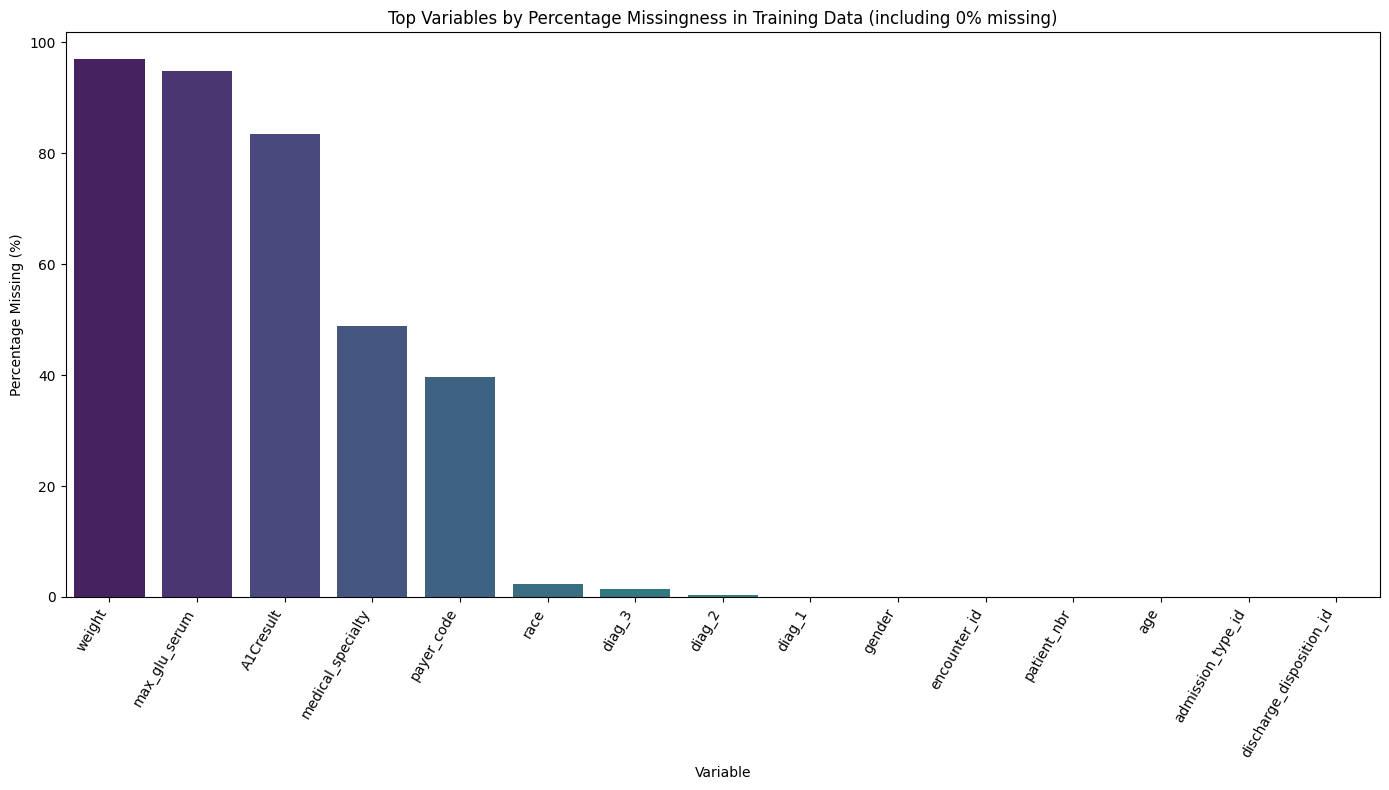

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'missing_train_df' in locals() and not missing_train_df.empty:
    # Get columns with 0% missingness
    zero_missing_cols = X_train.columns[X_train.isnull().sum() == 0].tolist()

    # Exclude columns already in missing_train_df's index
    zero_missing_cols = [col for col in zero_missing_cols if col not in missing_train_df.index]

    # Select the first 5 of these zero-missing columns (or fewer if less than 5 are available)
    additional_cols_for_plot = zero_missing_cols[:5]

    # Create a DataFrame for these additional columns with 0% missing
    if additional_cols_for_plot:
        additional_missing_df = pd.DataFrame({
            'Missing Count': [0] * len(additional_cols_for_plot),
            '% Missing': [0.0] * len(additional_cols_for_plot)
        }, index=additional_cols_for_plot)

        # Combine the original missing_train_df with the additional zero-missing columns
        combined_missing_df = pd.concat([missing_train_df, additional_missing_df])
    else:
        combined_missing_df = missing_train_df

    # Select the top 15 entries from the combined DataFrame
    top_15_for_plot = combined_missing_df.head(15)

    plt.figure(figsize=(14, 8))
    sns.barplot(x=top_15_for_plot.index, y=top_15_for_plot['% Missing'], palette='viridis', hue=top_15_for_plot.index, legend=False)
    plt.title('Top Variables by Percentage Missingness in Training Data (including 0% missing)')
    plt.xlabel('Variable')
    plt.ylabel('Percentage Missing (%)')
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("missing_train_df not found or is empty. Please run the missingness audit cells first.")

2.3- Distribution of 3 continuous variables

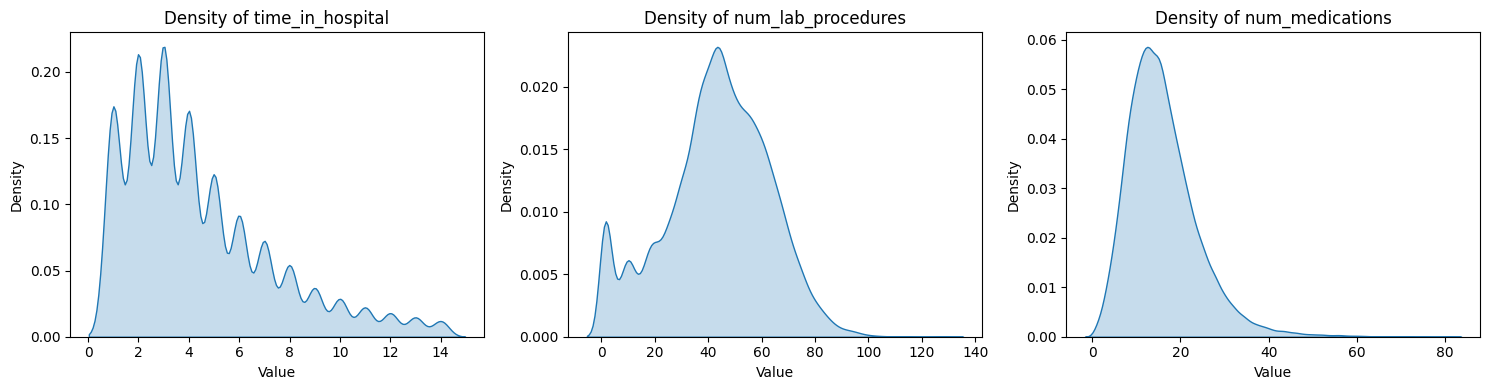

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_for_side_by_side_plots = [
    'time_in_hospital', 'num_lab_procedures', 'num_medications'
]

# Determine grid size for subplots
n_vars = len(variables_for_side_by_side_plots)
n_cols = 3  # Number of columns for subplots, adjusted for 3 variables
n_rows = (n_vars + n_cols - 1) // n_cols # Calculate rows needed

plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figure size dynamically

for i, col in enumerate(variables_for_side_by_side_plots):
    plt.subplot(n_rows, n_cols, i + 1) # Position subplot
    if col in X_train.columns:
        sns.kdeplot(X_train[col], fill=True)
        plt.title(f'Density of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')
    else:
        plt.title(f"'{col}' not found")
        plt.text(0.5, 0.5, 'Variable not found', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

2.4 - List of 3 variables with missingness <5% and 3 variables with missingness >30%

      - All variables with missingness should be investigated to assess whether the is evidence that values are "missing not at random (MNAR)" vs. "missing at random (MAR)" .
      - Values MAR with missingness < 5% should be imputed preferably using multiple imputation with methods such as "multiple imputation by chained equations (MICE)".
      - imputation should not be used if missingness is not at random, or if missingness is >30%.
    

In [22]:
print("Summary of Variables by Missingness:")
print("------------------------------------")

if 'missing_train_df' in locals() and not missing_train_df.empty:
    # Variables with <5% missingness
    low_missing_vars = missing_train_df[missing_train_df['% Missing'] < 5].head(3)

    # Variables with >30% missingness
    high_missing_vars = missing_train_df[missing_train_df['% Missing'] > 30].head(3)

    print("\nVariables with <5% Missingness:")
    if not low_missing_vars.empty:
        display(low_missing_vars)
    else:
        print("None found.")

    print("\nVariables with >30% Missingness:")
    if not high_missing_vars.empty:
        display(high_missing_vars)
    else:
        print("None found.")
else:
    print("missing_train_df not found or is empty. Please run the missingness audit cells first.")

Summary of Variables by Missingness:
------------------------------------

Variables with <5% Missingness:


,Missing Count,% Missing
race,1471,2.262972
diag_3,904,1.390705
diag_2,218,0.335369



Variables with >30% Missingness:


,Missing Count,% Missing
weight,63018,96.946295
max_glu_serum,61584,94.740243
A1Cresult,54211,83.397689


2.5 - What is the overall value distribution for some specific variables like 'gender', 'race', 'age', and 'diag_1'?

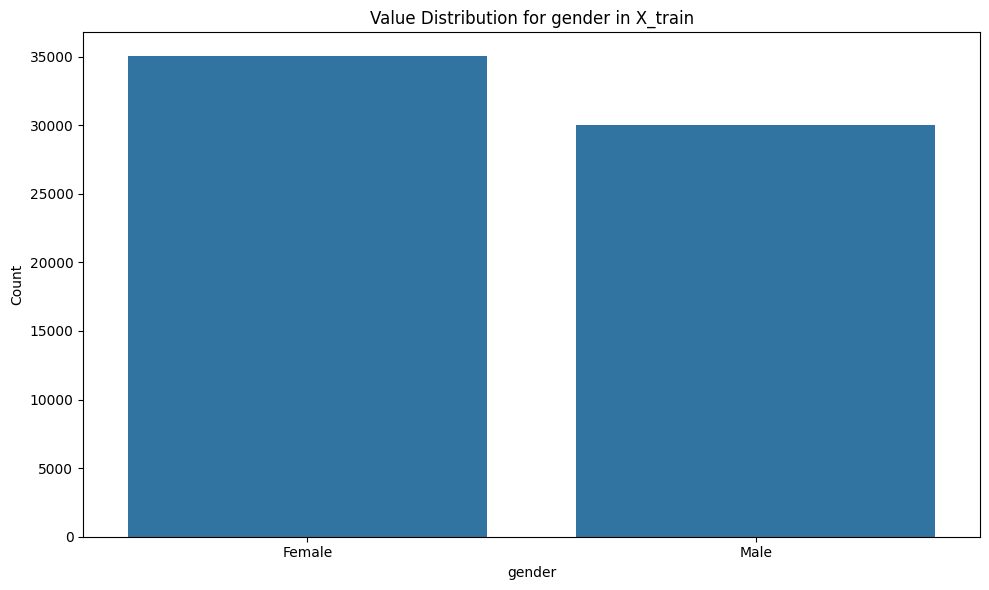

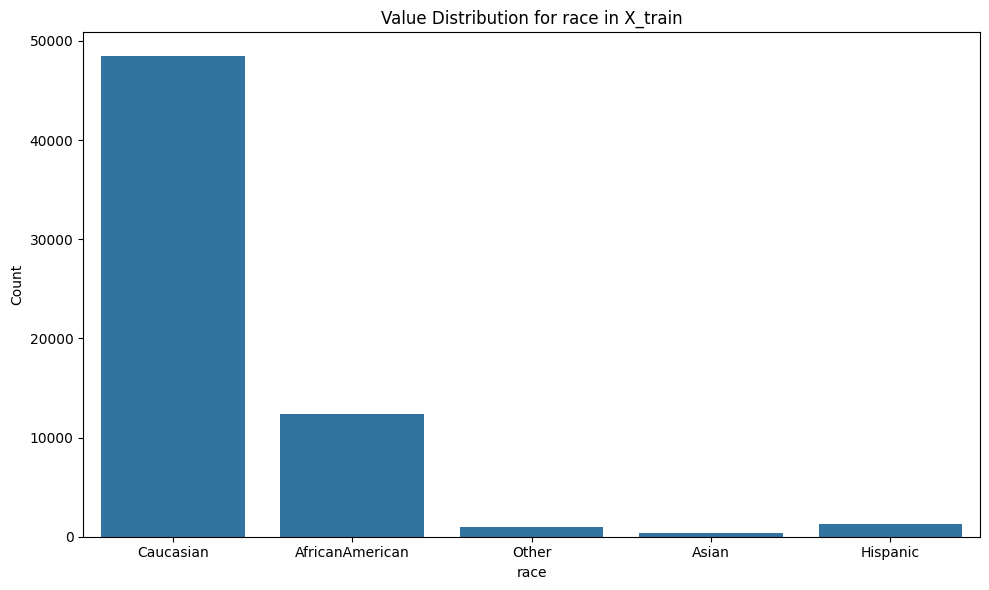

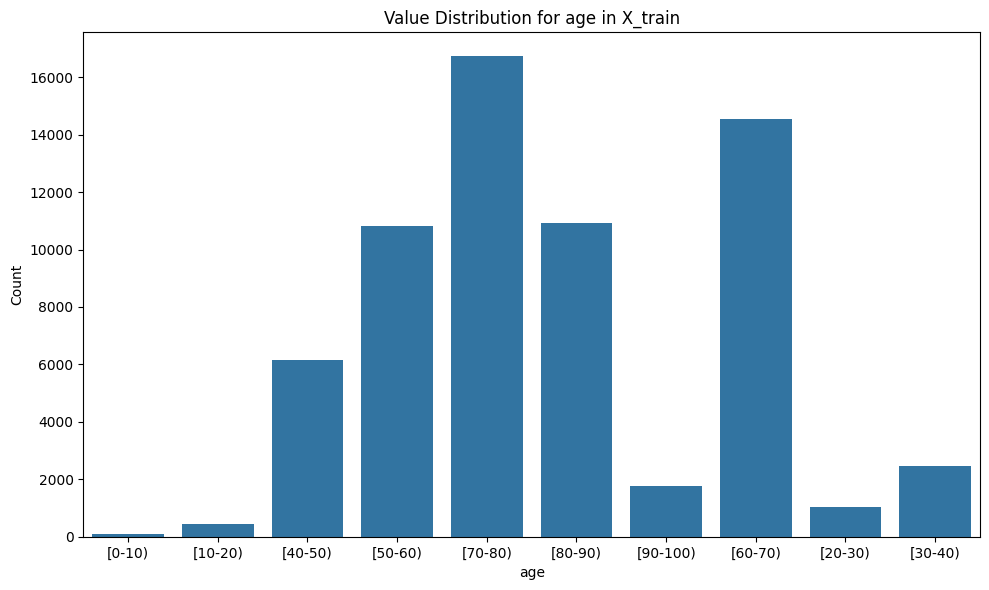

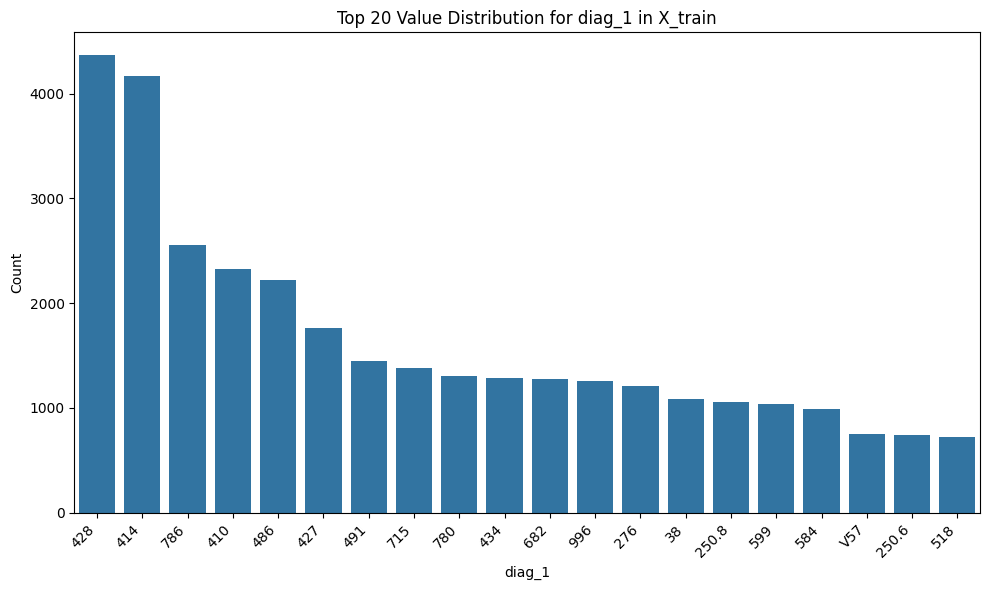

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_plot = ['gender', 'race', 'age', 'diag_1']

for var in variables_to_plot:
    plt.figure(figsize=(10, 6))
    if var == 'diag_1': # Handle potential large number of unique values for diag_1
        top_n = X_train[var].value_counts().nlargest(20)
        sns.barplot(x=top_n.index, y=top_n.values)
        plt.title(f'Top 20 Value Distribution for {var} in X_train')
        plt.xticks(rotation=45, ha='right')
    else:
        sns.countplot(data=X_train, x=var)
        plt.title(f'Value Distribution for {var} in X_train')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

### 2.6 - Is missingness related to the readmission outcomes?

In [24]:
import scipy.stats as stats

print("Analyzing missingness in relation to readmission outcomes...")

# Get columns with missing values from X_train
missing_cols_train = X_train.columns[X_train.isnull().any()].tolist()

if not missing_cols_train:
    print("No missing values found in X_train for analysis.")
else:
    results = []
    for col in missing_cols_train:
        # Create a temporary DataFrame with the column, its missing indicator, and the target variable
        temp_df = pd.DataFrame({
            'is_missing': X_train[col].isnull(),
            'readmit30': y_train
        })

        # Calculate counts for contingency table
        missing_readmit_count = temp_df[(temp_df['is_missing'] == True) & (temp_df['readmit30'] == 1)].shape[0]
        missing_non_readmit_count = temp_df[(temp_df['is_missing'] == True) & (temp_df['readmit30'] == 0)].shape[0]
        non_missing_readmit_count = temp_df[(temp_df['is_missing'] == False) & (temp_df['readmit30'] == 1)].shape[0]
        non_missing_non_readmit_count = temp_df[(temp_df['is_missing'] == False) & (temp_df['readmit30'] == 0)].shape[0]

        # Calculate the average readmit30 rate for missing and non-missing groups
        missing_readmit_rate = temp_df[temp_df['is_missing'] == True]['readmit30'].mean()
        non_missing_readmit_rate = temp_df[temp_df['is_missing'] == False]['readmit30'].mean()

        p_value = np.nan
        # Perform Chi-squared test if there are enough observations in each category
        if (missing_readmit_count + missing_non_readmit_count > 0) and \
           (non_missing_readmit_count + non_missing_non_readmit_count > 0) and \
           (missing_readmit_count + non_missing_readmit_count > 0) and \
           (missing_non_readmit_count + non_missing_non_readmit_count > 0):
            contingency_table = [
                [missing_readmit_count, missing_non_readmit_count],
                [non_missing_readmit_count, non_missing_non_readmit_count]
            ]
            # Only perform chi2_contingency if all expected frequencies are >= 5
            # This is a common rule of thumb for the validity of the chi-squared test
            try:
                chi2, p, _, expected = stats.chi2_contingency(contingency_table)
                if np.all(expected >= 5):
                    p_value = p
            except ValueError: # Occurs if table dimensions are zero or contain NaNs
                pass

        results.append({
            'Column': col,
            'Missing Readmit Rate': missing_readmit_rate,
            'Non-Missing Readmit Rate': non_missing_readmit_rate,
            'P-value': p_value
        })

    results_df = pd.DataFrame(results)
    display(results_df.sort_values(by='Missing Readmit Rate', ascending=False))

    print("\nInterpretation: If 'Missing Readmit Rate' is significantly different from 'Non-Missing Readmit Rate' for a given column, then missingness in that column might be related to readmission outcomes. A small P-value (e.g., < 0.05) suggests that the observed difference is statistically significant.")

Analyzing missingness in relation to readmission outcomes...


,Column,Missing Readmit Rate,Non-Missing Readmit Rate,P-value
5,diag_1,0.230769,0.111602,NaN
4,medical_specialty,0.116476,0.106977,1.270379e-04
3,payer_code,0.115299,0.109218,1.661814e-02
9,A1Cresult,0.114479,0.097294,2.465679e-07
2,weight,0.111349,0.120403,2.205547e-01
8,max_glu_serum,0.110889,0.124890,1.232973e-02
0,race,0.080218,0.112353,1.294637e-04
6,diag_2,0.077982,0.111739,1.409176e-01
7,diag_3,0.063053,0.112311,3.892795e-06
1,gender,0.000000,0.111629,NaN



Interpretation: If 'Missing Readmit Rate' is significantly different from 'Non-Missing Readmit Rate' for a given column, then missingness in that column might be related to readmission outcomes. A small P-value (e.g., < 0.05) suggests that the observed difference is statistically significant.


The table above shows the readmission rates when a particular feature is missing versus when it is present. A substantial difference between these two rates could indicate that the missingness itself provides information about the readmission outcome. For instance, if the 'Missing Readmit Rate' for a column is much higher than its 'Non-Missing Readmit Rate', it suggests that patients for whom that data point is absent might have a higher propensity for readmission. This can be a form of *informative missingness*.

### 2.7 - Is missingness related to outcomes? Analysis of 3 specific variables with missingness >15%

In [25]:
import scipy.stats as stats

print("Analyzing readmission rates based on missingness indicators:")

variables_to_analyze = ['payer_code', 'medical_specialty', 'A1Cresult']

results_missing_indicators = []

for col in variables_to_analyze:
    # Create the binary indicator for missingness
    X_train[f'is_missing_{col}'] = X_train[col].isnull().astype(int)

    # Calculate counts for contingency table
    missing_readmit_count = y_train[X_train[f'is_missing_{col}'] == 1].sum()
    missing_non_readmit_count = (X_train[f'is_missing_{col}'] == 1).sum() - missing_readmit_count
    non_missing_readmit_count = y_train[X_train[f'is_missing_{col}'] == 0].sum()
    non_missing_non_readmit_count = (X_train[f'is_missing_{col}'] == 0).sum() - non_missing_readmit_count

    # Calculate readmission rate for missing vs. not missing
    readmit_rate_missing = y_train[X_train[f'is_missing_{col}'] == 1].mean()
    readmit_rate_not_missing = y_train[X_train[f'is_missing_{col}'] == 0].mean()

    p_value = np.nan
    # Perform Chi-squared test if there are enough observations in each category
    if (missing_readmit_count + missing_non_readmit_count > 0) and \
       (non_missing_readmit_count + non_missing_non_readmit_count > 0) and \
       (missing_readmit_count + non_missing_readmit_count > 0) and \
       (missing_non_readmit_count + non_missing_non_readmit_count > 0):
        contingency_table = [
            [missing_readmit_count, missing_non_readmit_count],
            [non_missing_readmit_count, non_missing_non_readmit_count]
        ]
        try:
            chi2, p, _, expected = stats.chi2_contingency(contingency_table)
            # Common rule of thumb for chi-squared validity: all expected frequencies >= 5
            if np.all(expected >= 5):
                p_value = p
        except ValueError: # Occurs if table dimensions are zero or contain NaNs
            pass

    results_missing_indicators.append({
        'Variable': col,
        'Readmission Rate (Missing)': readmit_rate_missing,
        'Readmission Rate (Not Missing)': non_missing_readmit_rate,
        'P-value': p_value
    })

results_df_indicators = pd.DataFrame(results_missing_indicators)
display(results_df_indicators)

print("\nInterpretation: A significant difference between 'Readmission Rate (Missing)' and 'Readmission Rate (Not Missing)' for a variable suggests that the missingness itself might be an important predictor. A small P-value (e.g., < 0.05) suggests that the observed difference is statistically significant.")

# Drop the temporary indicator columns to keep X_train clean for subsequent steps, if any.
# Or keep them if they are intended for feature engineering.
for col in variables_to_analyze:
    X_train = X_train.drop(columns=[f'is_missing_{col}'])

Analyzing readmission rates based on missingness indicators:


,Variable,Readmission Rate (Missing),Readmission Rate (Not Missing),P-value
0,payer_code,0.115299,0.097294,1.661814e-02
1,medical_specialty,0.116476,0.097294,1.270379e-04
2,A1Cresult,0.114479,0.097294,2.465679e-07



Interpretation: A significant difference between 'Readmission Rate (Missing)' and 'Readmission Rate (Not Missing)' for a variable suggests that the missingness itself might be an important predictor. A small P-value (e.g., < 0.05) suggests that the observed difference is statistically significant.


*A significant difference (p< 0.05) between 'Readmission Rate (Missing)' and 'Readmission Rate (Not Missing)' for a variable suggests that the missingness itself might be an important predictor for readmission.*

# **3- Minimal data quality check**
     1- Dublicates
     2- Outliers / Validity
     3- leakage screen

### 3.1 Duplicates
  - Table including the patients with highest duplicate values with the number of duplicate values in both training and testing data

In [26]:
columns_to_check = ['patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'row_id', 'encounter_id']

print("Checking for duplicate values in specific columns:")

for col in columns_to_check:
    print(f"\n--- Column: {col} ---")

    # Check X_train
    duplicates_xtrain = X_train[col].duplicated().sum()
    if duplicates_xtrain > 0:
        print(f"  X_train: {duplicates_xtrain} duplicate entries")
    else:
        print(f"  X_train: No duplicate entries")

    # Check test
    duplicates_test = test[col].duplicated().sum()
    if duplicates_test > 0:
        print(f"  Test: {duplicates_test} duplicate entries")
    else:
        print(f"  Test: No duplicate entries")

Checking for duplicate values in specific columns:

--- Column: patient_nbr ---
  X_train: 19232 duplicate entries
  Test: 4871 duplicate entries

--- Column: admission_type_id ---
  X_train: 64995 duplicate entries
  Test: 16306 duplicate entries

--- Column: discharge_disposition_id ---
  X_train: 64977 duplicate entries
  Test: 16289 duplicate entries

--- Column: admission_source_id ---
  X_train: 64986 duplicate entries
  Test: 16302 duplicate entries

--- Column: row_id ---
  X_train: No duplicate entries
  Test: No duplicate entries

--- Column: encounter_id ---
  X_train: No duplicate entries
  Test: No duplicate entries


### 3.2 - Outliers /Validity

Summary Statistics (Min, Median, Max, 1st & 99th Percentile) for Numeric Variables:
----------------------------------------------------------------------------------

--- Variable: num_lab_procedures ---
  Minimum: 1
  1st Percentile: 1.0
  Median: 44.0
  99th Percentile: 85.0
  Maximum: 129

--- Variable: num_procedures ---
  Minimum: 0
  1st Percentile: 0.0
  Median: 1.0
  99th Percentile: 6.0
  Maximum: 6

--- Variable: num_medications ---
  Minimum: 1
  1st Percentile: 3.0
  Median: 15.0
  99th Percentile: 43.0
  Maximum: 81

Generating Boxplots for Numeric Variables...


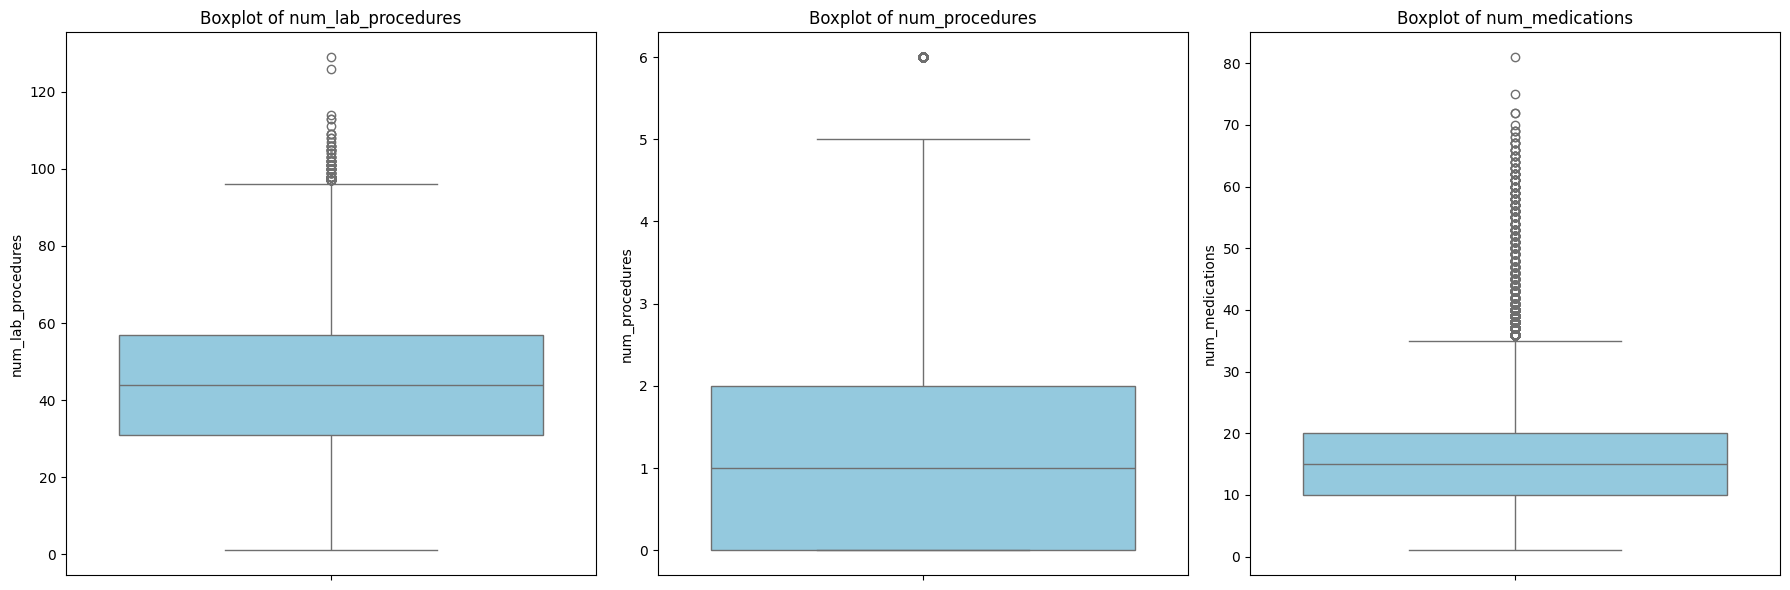

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_analyze = ['num_lab_procedures', 'num_procedures', 'num_medications']

print("Summary Statistics (Min, Median, Max, 1st & 99th Percentile) for Numeric Variables:")
print("----------------------------------------------------------------------------------")

for col in variables_to_analyze:
    if col in X_train.columns:
        print(f"\n--- Variable: {col} ---")
        minimum = X_train[col].min()
        median = X_train[col].median()
        maximum = X_train[col].max()
        p1 = X_train[col].quantile(0.01)
        p99 = X_train[col].quantile(0.99)

        print(f"  Minimum: {minimum}")
        print(f"  1st Percentile: {p1}")
        print(f"  Median: {median}")
        print(f"  99th Percentile: {p99}")
        print(f"  Maximum: {maximum}")
    else:
        print(f"Variable '{col}' not found in X_train.")

print("\nGenerating Boxplots for Numeric Variables...")

plt.figure(figsize=(18, 6))
for i, col in enumerate(variables_to_analyze):
    if col in X_train.columns:
        plt.subplot(1, len(variables_to_analyze), i + 1)
        sns.boxplot(y=X_train[col], color='skyblue')
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
    else:
        print(f"Could not generate boxplot for '{col}' as it's not in X_train.")
plt.tight_layout()
plt.show()

### 3.3 - Leakage Screen
    - The 2 leakage variables are discharge_disposition_id and admission_type_id



--- Analyzing discharge_disposition_id for leakage ---


,discharge_disposition_id,Readmit_Rate
11,12,1.000000
14,15,0.500000
25,28,0.425532
8,9,0.333333
20,22,0.272167
4,5,0.209424
22,24,0.181818
1,2,0.165179
6,7,0.163539
2,3,0.144970


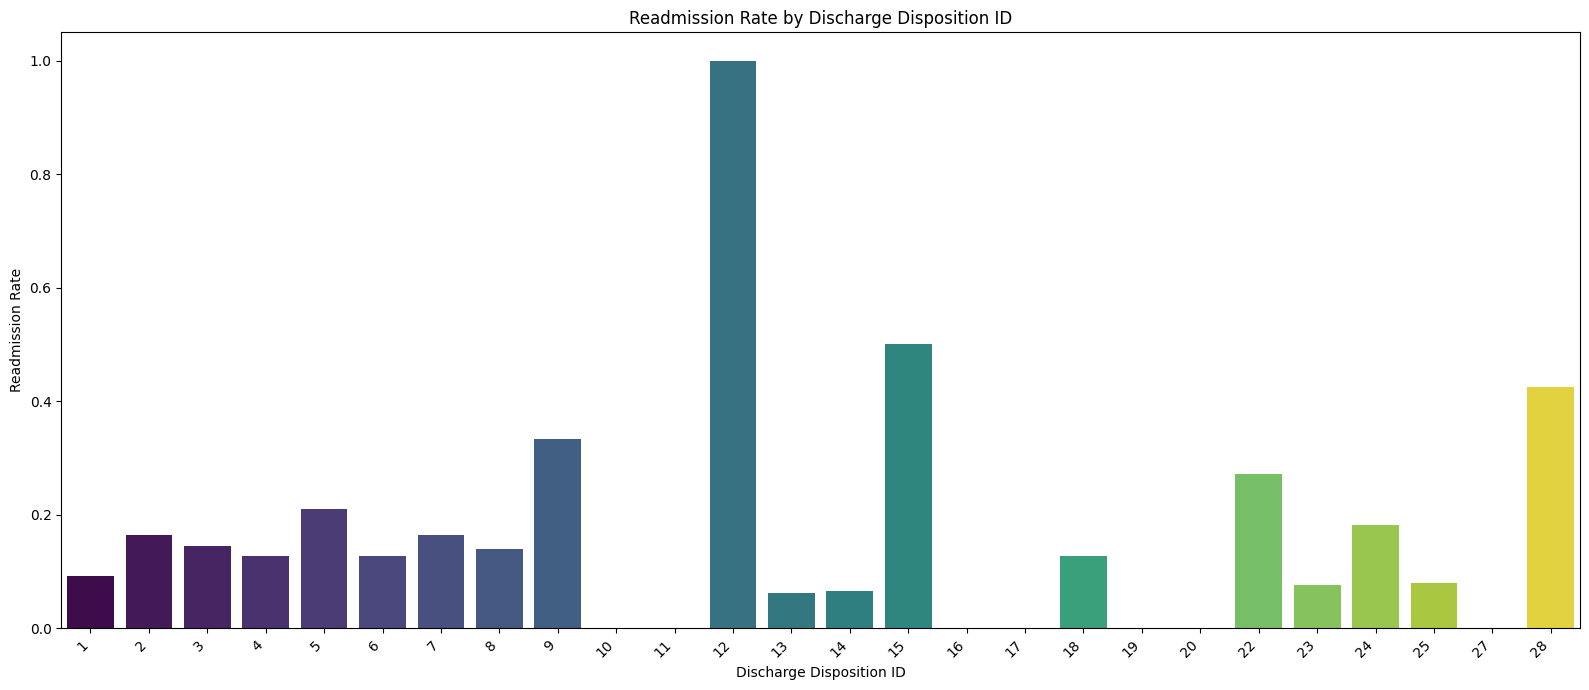

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Analyzing discharge_disposition_id for leakage ---")
disposition_readmit_rates = train.groupby('discharge_disposition_id')['readmit30'].mean().reset_index()
disposition_readmit_rates.columns = ['discharge_disposition_id', 'Readmit_Rate']

# Sort by readmission rate for better visualization
disposition_readmit_rates = disposition_readmit_rates.sort_values(by='Readmit_Rate', ascending=False)

display(disposition_readmit_rates)

plt.figure(figsize=(16, 7))
sns.barplot(x='discharge_disposition_id', y='Readmit_Rate', data=disposition_readmit_rates, palette='viridis', hue='discharge_disposition_id', legend=False)
plt.title('Readmission Rate by Discharge Disposition ID')
plt.xlabel('Discharge Disposition ID')
plt.ylabel('Readmission Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Analyzing admission_type_id for leakage ---")
admission_readmit_rates = train.groupby('admission_type_id')['readmit30'].mean().reset_index()
admission_readmit_rates.columns = ['admission_type_id', 'Readmit_Rate']

# Sort by readmission rate for better visualization
admission_readmit_rates = admission_readmit_rates.sort_values(by='Readmit_Rate', ascending=False)

display(admission_readmit_rates)

plt.figure(figsize=(12, 6))
sns.barplot(x='admission_type_id', y='Readmit_Rate', data=admission_readmit_rates, palette='coolwarm', hue='admission_type_id', legend=False)
plt.title('Readmission Rate by Admission Type ID')
plt.xlabel('Admission Type ID')
plt.ylabel('Readmission Rate')
plt.tight_layout()
plt.show()

# **Statistical Analysis**

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# TODO: Add any new imports for your own method here
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

method = 4

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
)

if method==1:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200)),
    ])

if method==2:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200,class_weight='balanced')),
    ])

if method==3:
    # Use SVC (i.e. SVM model)
    clf = Pipeline(
        [
            ("preprocess", preprocess),
            ("scaler", StandardScaler(with_mean=False)), # Add StandardScaler here
            ("model", SVC(gamma="auto",max_iter=1000,probability=True)),
        ]
    )

if method == 4:
    # Preprocess for HGB: ordinal-encode categories (HGB needs numeric inputs)
    preprocess_hgb = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ]), cat_cols),
        ],
        remainder="drop",
    )

    clf = Pipeline([
        ("preprocess", preprocess_hgb),
        ("model", HistGradientBoostingClassifier(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42,
            class_weight='balanced',
        )),
    ])

clf.fit(X_train, y_train)

In [ ]:
p_test = hgb_model.predict_proba(test_processed)[:, 1]
pred = pd.DataFrame({"row_id": test_processed["row_id"].astype(int), "prob_readmit30": p_test.astype(float)})
pred.to_csv(OUT_PATH, index=False)
pred.head()

In [ ]:
# Validate output format (required for students before tagging)
!python Project-1/readmit30/scripts/validate_submission.py --pred {OUT_PATH} --test {TEST_PATH}


In [ ]:
# Calculate metrics for the dev set
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import matplotlib.pyplot as plt

dev = pd.read_csv(DEV_PATH)

X_dev = dev.drop(columns=["readmit30"])
y_dev = dev["readmit30"].astype(int)

# Calculate metrics
y_true = y_dev.astype(int)
y_pred = clf.predict_proba(X_dev)[:, 1]

auroc = roc_auc_score(y_true, y_pred)
auprc = average_precision_score(y_true, y_pred)
brier = brier_score_loss(y_true, y_pred)

print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(f'Brier Score: {brier:.4f}')

# Create figures
plt.figure(figsize=(10, 6))

# Histogram of predicted probabilities
plt.hist(y_pred, bins=20, alpha=0.7, label='Predicted Probabilities')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of true vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='True vs Predicted')
plt.title('True vs Predicted Probabilities')
plt.xlabel('True Labels')
plt.ylabel('Predicted Probabilities')
plt.legend()
plt.show()

# Create ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Create Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Create Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold = 0.5  # Default threshold for binary classification
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Readmit', 'Readmit'], yticklabels=['No Readmit', 'Readmit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#MAINEND

## 5) Validate the predictions file format

This checks:
- required columns
- probabilities in [0, 1]
- row_ids match the test file

It assumes the submission notebook wrote `predictions.csv` in the repo root.


In [ ]:
from pathlib import Path
pred_path = Path("predictions.csv")
test_path = Path("Project-1/readmit30/scripts/data/public/public_test.csv")

if not pred_path.exists():
    print("predictions.csv not found. Run notebooks/submission.ipynb first.")
else:
    !python Project-1/readmit30/scripts/validate_submission.py --pred predictions.csv --test Project-1/readmit30/scripts/data/public/public_test.csv

## 6) Commit + push + tag

You will:
- add changes
- commit (pre-commit hook runs here)
- push
- tag a milestone (example: `milestone_wk3`) and push tags



You will need a Personal Access Token (PAT) for the following step. See instructions above.

In [ ]:
# ==== Colab -> GitHub commit/push for a specific notebook path (PAT auth) ====
# What this does:
#  1) clones the repo into the Colab VM
#  2) overwrites the target notebook file with the *currently open* Colab notebook
#  3) commits the change
#  4) asks you for a GitHub PAT and pushes to the target branch
#  5) (optional) creates a git tag and pushes the tag
#
# Notes:
#  - PAT is read via getpass (not echoed). It is only used for this runtime session.
#  - This overwrites the file at TARGET_REL with the *current Colab notebook contents*.

import os
import json
import subprocess
import getpass
from google.colab import _message

# ==========================
# START USER-EDITABLE SETTINGS
# ==========================
# Repo settings
REPO_HTTPS = "https://github.com/TLKline/AIHC-5010-Winter-2026.git"  # full https clone URL ending in .git
REPO_DIR   = "AIHC-5010-Winter-2026"                                # folder name to clone into (or reuse)

# Git settings
BRANCH     = "main"                                                 # branch to commit/push to
COMMIT_MSG = "Update Assignment1_Colab_Workflow.ipynb from Colab test5"    # commit message

# File to overwrite inside the repo (relative to repo root)
TARGET_REL = "Project-1/readmit30/notebooks/Assignment1_Colab_Workflow.ipynb"

# Identity for commits
GIT_USER_NAME  = "Timothy Kline"
GIT_USER_EMAIL = "kline.timothy@mayo.edu"

# (Optional) If you want to push to a different remote than REPO_HTTPS, set it here.
# Leave as None to use REPO_HTTPS.
PUSH_REMOTE_HTTPS = None  # e.g. "https://github.com/<user>/<repo>.git"

# Set TAG_NAME to something like "assignment1-submission-v1".
# Leave as "" (empty string) to skip tagging.
TAG_NAME    = "assignment1-submission-v01"  # e.g. "assignment1-submission-v1"
TAG_MESSAGE = "Assignment 1 submission"  # used only for annotated tags
TAG_ANNOTATED = True  # True = annotated tag (-a -m). False = lightweight tag.
# ==========================
# END USER-EDITABLE SETTINGS
# ==========================


def run(cmd, cwd=None, check=True):
    """Run a shell command and stream output."""
    print(f"\n$ {' '.join(cmd)}")
    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True)
    if p.stdout:
        print(p.stdout)
    if p.stderr:
        print(p.stderr)
    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed with exit code {p.returncode}: {' '.join(cmd)}")
    return p


def github_authed_remote(https_remote: str, token: str) -> str:
    """
    Convert https://github.com/OWNER/REPO.git into https://TOKEN@github.com/OWNER/REPO.git
    Works for standard GitHub HTTPS remotes.
    """
    if https_remote.startswith("https://"):
        return "https://" + token + "@" + https_remote[len("https://"):]
    raise ValueError("Expected an https remote URL (starting with https://).")


def tag_exists_locally(tag_name: str, cwd: str) -> bool:
    p = subprocess.run(["git", "tag", "-l", tag_name], cwd=cwd, text=True, capture_output=True)
    return p.stdout.strip() == tag_name


REMOTE_FOR_PUSH = PUSH_REMOTE_HTTPS or REPO_HTTPS

# 1) Clone (or reuse existing clone)
if not os.path.isdir(REPO_DIR):
    run(["git", "clone", REPO_HTTPS, REPO_DIR])
else:
    print(f"Repo directory already exists: {REPO_DIR}")

# Ensure we're on the right branch and up-to-date
run(["git", "checkout", BRANCH], cwd=REPO_DIR)
run(["git", "pull", "origin", BRANCH], cwd=REPO_DIR)

# 2) Get the currently-open notebook JSON from Colab
nb = _message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]

# 3) Overwrite the target file in the clone
target_abs = os.path.join(os.getcwd(), REPO_DIR, TARGET_REL)
os.makedirs(os.path.dirname(target_abs), exist_ok=True)
with open(target_abs, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Wrote current Colab notebook to:")
print(" ", target_abs)

# 4) Configure git identity
run(["git", "config", "user.name", GIT_USER_NAME], cwd=REPO_DIR)
run(["git", "config", "user.email", GIT_USER_EMAIL], cwd=REPO_DIR)

# 5) Show status; if no changes, stop early
status = run(["git", "status", "--porcelain"], cwd=REPO_DIR, check=True).stdout.strip()
if not status:
    print("\nNo changes detected in the repo after writing the notebook.")
    print("Double-check that you're running this cell inside the notebook you edited,")
    print("and that TARGET_REL points to the correct path inside the repo.")
else:
    # 6) Add + commit
    run(["git", "add", TARGET_REL], cwd=REPO_DIR)

    commit_proc = subprocess.run(
        ["git", "commit", "-m", COMMIT_MSG],
        cwd=REPO_DIR, text=True, capture_output=True
    )
    if commit_proc.stdout:
        print(commit_proc.stdout)
    if commit_proc.stderr:
        print(commit_proc.stderr)

    combined = (commit_proc.stdout + commit_proc.stderr).lower()
    if commit_proc.returncode != 0 and "nothing to commit" not in combined:
        raise RuntimeError("git commit failed unexpectedly")

    # 7) Ask for PAT and push
    print("\nEnter a GitHub Personal Access Token (PAT) with permission to push to this repo.")
    print("Recommended: fine-grained token with access to the repo and Contents: Read/Write.")
    token = getpass.getpass("GitHub PAT (input hidden): ").strip()
    if not token:
        raise ValueError("No token entered.")

    # Temporarily set authenticated remote URL for this push only (and for tag push)
    authed_remote = github_authed_remote(REMOTE_FOR_PUSH, token)
    run(["git", "remote", "set-url", "origin", authed_remote], cwd=REPO_DIR)

    try:
        # Push commits
        run(["git", "push", "origin", BRANCH], cwd=REPO_DIR)
        print(f"\n Pushed successfully to {BRANCH}.")

        # 8) OPTIONAL: Create + push tag
        if TAG_NAME.strip():
            tag_name = TAG_NAME.strip()

            # If tag already exists locally, don't recreate
            if tag_exists_locally(tag_name, REPO_DIR):
                print(f"Tag already exists locally: {tag_name}")
            else:
                if TAG_ANNOTATED:
                    run(["git", "tag", "-a", tag_name, "-m", TAG_MESSAGE], cwd=REPO_DIR)
                else:
                    run(["git", "tag", tag_name], cwd=REPO_DIR)
                print(f"Created tag: {tag_name}")

            # Push just this tag (or use --tags to push all tags)
            run(["git", "push", "origin", tag_name], cwd=REPO_DIR)
            print(f" Pushed tag: {tag_name}")
        else:
            print("Skipping tag creation (TAG_NAME is empty).")

        print("\nDone. Check GitHub for the new commit (and tag, if set).")

    finally:
        # Restore remote URL without token
        run(["git", "remote", "set-url", "origin", REPO_HTTPS], cwd=REPO_DIR, check=False)


## Done ✅

If you hit issues:
- Make sure you pulled the latest course template (missing files).
- Make sure `data/public/*` exists in your repo (or your instructor provided it separately).


create a supervised model to predict readmit30 using the specified covariates. The plan includes handling missing values, excluding leakage variables, preparing data, training and evaluating four different models (Logistic Regression with default and balanced class weights, SVC, and HistGradientBoostingClassifier), and finally, comparing their performance in a table.

Select Covariates and Exclude High Missingness & Leakage Variables: First, filter X_train and test to include only the specified covariates. Then, based on the EDA, drop columns identified with >30% missingness (weight, max_glu_serum, A1Cresult, medical_specialty, payer_code) and leakage variables (admission_type_id) from these filtered DataFrames.
Impute Low Missingness Variables: Based on the EDA, identify variables with <6% missingness (race, gender) from the remaining covariates. For these categorical columns, use SimpleImputer with strategy 'most_frequent'. Apply this imputation to both X_train and test.
Identify and Transform Data Types: Identify numerical and categorical columns from the remaining covariates. The numerical columns will be processed with SimpleImputer(strategy="median") and StandardScaler. Categorical columns will be processed with SimpleImputer(strategy="most_frequent") followed by OneHotEncoder for Logistic Regression and SVC, and OrdinalEncoder for HistGradientBoostingClassifier.
Model Training and Evaluation - Method 1: Logistic Regression (default): Set up a pipeline with appropriate preprocessing (imputation, one-hot encoding for categorical, median imputation for numerical) and LogisticRegression(max_iter=200). Train the model on X_train and y_train. Predict probabilities on X_dev and calculate AUROC, AUPRC, and Brier Score. Store these metrics in a dictionary.
Model Training and Evaluation - Method 2: Logistic Regression (balanced class weight): Set up a pipeline with appropriate preprocessing (same as Method 1) and LogisticRegression(max_iter=200, class_weight='balanced'). Train the model on X_train and y_train. Predict probabilities on X_dev and calculate AUROC, AUPRC, and Brier Score. Store these metrics in a dictionary.
Model Training and Evaluation - Method 3: SVC (with StandardScaler): Set up a pipeline with appropriate preprocessing (imputation, one-hot encoding for categorical, median imputation for numerical), StandardScaler, and SVC(gamma='auto', max_iter=1000, probability=True). Train the model on X_train and y_train. Predict probabilities on X_dev and calculate AUROC, AUPRC, and Brier Score. Store these metrics in a dictionary.
Model Training and Evaluation - Method 4: HistGradientBoostingClassifier (with OrdinalEncoder): Set up a pipeline with appropriate preprocessing using OrdinalEncoder for categorical features and HistGradientBoostingClassifier(max_depth=6, learning_rate=0.05, max_iter=300, l2_regularization=1.0, early_stopping=True, random_state=42, class_weight='balanced'). Train the model on X_train and y_train. Predict probabilities on X_dev and calculate AUROC, AUPRC, and Brier Score. Store these metrics in a dictionary.
Compare Model Performance: Create a pandas DataFrame to display the AUROC, AUPRC, and Brier Score for all four models. Print the table to the console.
Final Task: Summarize the best performing model based on the comparison and discuss potential next steps for model improvement.

# **4 - Supervised Learning**

### 4.1 - Impute Low Missingness Variables
Impute categorical variables with less than 5% missingness using the 'most_frequent' strategy and drop identified leakage variables from the processed dataframes.


4.1.1 - First, create copies of the original dataframes to avoid modifying them directly. This ensures that the original data remains intact for other potential uses.



In [29]:
X_train_processed = X_train.copy()
test_processed = test.copy()

print("Created copies of X_train and test as X_train_processed and test_processed.")

Created copies of X_train and test as X_train_processed and test_processed.


4.1.2 - Drop the identified leakage variables, `discharge_disposition_id` and `admission_type_id`, from both `X_train_processed` and `test_processed` as specified in instruction #2.



In [30]:
columns_to_drop = ['discharge_disposition_id', 'admission_type_id']
X_train_processed = X_train_processed.drop(columns=columns_to_drop)
test_processed = test_processed.drop(columns=columns_to_drop)

print(f"Dropped columns {columns_to_drop} from X_train_processed and test_processed.")

Dropped columns ['discharge_disposition_id', 'admission_type_id'] from X_train_processed and test_processed.


4.1.3 - Identify the specified categorical columns ('race' and 'gender') and impute their missing values using the 'most_frequent' strategy.

In [31]:
from sklearn.impute import SimpleImputer

# Based on previous EDA and instruction 3, the columns to impute are 'race' and 'gender'.
imputation_cols = ['race', 'gender']

# Apply SimpleImputer for 'most_frequent' strategy to identified categorical columns
for col in imputation_cols:
    if col in X_train_processed.columns:
        imputer = SimpleImputer(strategy='most_frequent')
        # Fit and transform on X_train_processed and flatten the output to 1D
        X_train_processed[col] = imputer.fit_transform(X_train_processed[[col]]).ravel()
        # Transform test_processed using the same imputer and flatten the output to 1D
        test_processed[col] = imputer.transform(test_processed[[col]]).ravel()


### 4.2 - Identify and Transform Data Types
Identify numerical and categorical columns from the processed dataframes to prepare for model-specific preprocessing pipelines.


In [32]:
numerical_cols = []
categorical_cols = []

for col in X_train_processed.columns:
    if X_train_processed[col].dtype in ['int64', 'float64']:
        numerical_cols.append(col)
    elif X_train_processed[col].dtype == 'object' or X_train_processed[col].dtype == 'string':
        categorical_cols.append(col)

print("Identified Numerical Columns:", numerical_cols)
print("\nIdentified Categorical Columns:", categorical_cols)

Identified Numerical Columns: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Identified Categorical Columns: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'row_id']


### 5 - Method 1: Logistic Regression (default)
Train a Logistic Regression model with default settings, including appropriate preprocessing, and evaluate its performance on the development set.


5.1 - Imputation of numeric features using an interative imputer process (MICE)
Sale continuous variables using StandardScaler.

In [33]:
from sklearn.experimental import enable_iterative_imputer # Explicitly import for experimental feature
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import pandas as pd
import numpy as np

# 1. Define a preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)), # Changed to IterativeImputer (MICE)
    ('scaler', StandardScaler())
])

print("Numerical preprocessing pipeline defined.")

Numerical preprocessing pipeline defined.


5.2 - Categorical features were imputed using `SimpleImputer` with the 'most_frequent' strategy and `OneHotEncoder`.



In [34]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

print("Categorical preprocessing pipeline defined.")

Categorical preprocessing pipeline defined.


5.3 - Combine the numerical and categorical preprocessing steps using `ColumnTransformer`. This will create a `preprocessor` that can be used in the final model pipeline.



In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

print("ColumnTransformer (preprocessor) defined.")

ColumnTransformer (preprocessor) defined.


5.4 - `Pipeline` that integrates the `preprocessor` and the `LogisticRegression` model with `max_iter=200`. Then, train this pipeline on the `X_train_processed` and `y_train` datasets.



In [36]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# 5. Train this pipeline on X_train_processed and y_train
model.fit(X_train_processed, y_train)

print("Logistic Regression model pipeline defined and trained.")

Logistic Regression model pipeline defined and trained.


5.5 - Preprocess the dataset by dropping leakage variables, and then use the trained Logistic Regression model to predict probabilities and then calculate
the evaluation metrics (AUROC, AUPRC, Brier Score) as per instructions 6, 7, 8, and 9.



In [37]:
model_performance = {}

# 6. Load and preprocess the development dataset
dev = pd.read_csv(DEV_PATH, na_values=['?', 'Unknown/Invalid'])
X_dev = dev.drop(columns=["readmit30"])
y_dev = dev["readmit30"].astype(int)

# Drop leakage variables from X_dev as they were dropped from X_train_processed
columns_to_drop = ['discharge_disposition_id', 'admission_type_id']
X_dev = X_dev.drop(columns=columns_to_drop)

# 7. Use the trained pipeline to predict probabilities on X_dev
y_pred_proba = model.predict_proba(X_dev)[:, 1]

# 8. Calculate the AUROC, AUPRC, and Brier Score
auroc = roc_auc_score(y_dev, y_pred_proba)
auprc = average_precision_score(y_dev, y_pred_proba)
brier = brier_score_loss(y_dev, y_pred_proba)

print(f"Logistic Regression (Default) - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}, Brier Score: {brier:.4f}")

# 9. Store the calculated metrics
model_performance['Logistic Regression (Default)'] = {
    'AUROC': auroc,
    'AUPRC': auprc,
    'Brier Score': brier
}

print("Evaluation metrics for Logistic Regression (Default) stored.")

Logistic Regression (Default) - AUROC: 0.6321, AUPRC: 0.1836, Brier Score: 0.0968
Evaluation metrics for Logistic Regression (Default) stored.


## 6 - Method 2: Logistic Regression (balanced class weight)
A logistic regression with balanced class weights is a logistic regression model that adjusts how much each class contribute to the loss function, so that **the minority classes are not overwhelmed by the majority classes**. With balanced class weights, the loss function is modified so that each class contributes proportionally to its inverse frequency.

### Subtask:
Train a Logistic Regression model with balanced class weights, including appropriate preprocessing, and evaluate its performance on the development set.

#### Instructions
1. Reuse the `preprocessor` defined previously.
2. Create a complete `Pipeline` that first applies the `preprocessor` and then a `LogisticRegression` model with `max_iter=200`, `random_state=42`, and `class_weight='balanced'`.
3. Train this pipeline on `X_train_processed` and `y_train`.
4. Use the trained pipeline to predict probabilities on `X_dev`.
5. Calculate the AUROC, AUPRC, and Brier Score using the true labels (`y_dev`) and the predicted probabilities.
6. Store the calculated metrics (AUROC, AUPRC, Brier Score) in the `model_performance` dictionary with a key like 'Logistic Regression (Balanced)'.

# Task
Identify the skewness of continuous numerical features in `X_train_processed` to categorize them into `normally_distributed_cols` (skewness between -0.5 and 0.5) and `skewed_cols`. Then, update the preprocessing pipeline for the 'Logistic Regression (Balanced)' model to use `IterativeImputer` and `StandardScaler` for normally distributed features, and `IterativeImputer` and `RobustScaler` for skewed features. Finally, retrain and re-evaluate the 'Logistic Regression (Balanced)' model on `X_train_processed` and `y_train`, assessing its performance on `X_dev` with the updated preprocessing, and report its updated performance metrics.

6.1 - Calculate the skewness for each numerical column in `X_train_processed` and then categorize them into two lists: `normally_distributed_cols` for those with skewness between -0.5 and 0.5, and `skewed_cols` for others. Print both lists to show the identified distributions.



In [38]:
import numpy as np
import pandas as pd

# 1. Calculate the skewness for each column in the numerical_cols list within X_train_processed.
# Ensure numerical_cols is up-to-date with the processed dataframe
numerical_cols_xtrain_processed = X_train_processed.select_dtypes(include=np.number).columns.tolist()
skewness_values = X_train_processed[numerical_cols_xtrain_processed].skew()

# 2. Create two lists based on skewness values
normally_distributed_cols = skewness_values[(skewness_values >= -0.5) & (skewness_values <= 0.5)].index.tolist()
skewed_cols = skewness_values[~((skewness_values >= -0.5) & (skewness_values <= 0.5))].index.tolist()

# 3. Print the normally_distributed_cols and skewed_cols lists.
print("Normally Distributed Columns (skewness between -0.5 and 0.5):")
print(normally_distributed_cols)
print("\nSkewed Columns (skewness outside -0.5 and 0.5):")
print(skewed_cols)

Normally Distributed Columns (skewness between -0.5 and 0.5):
['num_lab_procedures']

Skewed Columns (skewness outside -0.5 and 0.5):
['time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


6.2 - Update the numerical preprocessing pipeline for the 'Logistic Regression (Balanced)' model to apply different scalers based on feature skewness. Normally distributed columns will use `StandardScaler`, while skewed columns will use `RobustScaler`, both preceded by `IterativeImputer` for handling missing values.



In [39]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import pandas as pd
import numpy as np

# Define preprocessing pipelines for different numerical feature types
# For normally distributed features: IterativeImputer + StandardScaler
norm_num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())
])

# For skewed features: IterativeImputer + RobustScaler
skewed_num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', RobustScaler()) # Changed to RobustScaler
])

# Reuse the categorical_transformer defined previously
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Update the ColumnTransformer to use specialized pipelines for numerical features
preprocessor_advanced_scaling = ColumnTransformer(
    transformers=[
        ('norm_num', norm_num_transformer, normally_distributed_cols),
        ('skewed_num', skewed_num_transformer, skewed_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a new pipeline for Logistic Regression (Balanced) with the updated preprocessor
model_balanced_advanced = Pipeline(steps=[
    ('preprocessor', preprocessor_advanced_scaling),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# Train this pipeline on X_train_processed and y_train
model_balanced_advanced.fit(X_train_processed, y_train)

print("Logistic Regression (Balanced) model trained with advanced numerical scaling.")

Logistic Regression (Balanced) model trained with advanced numerical scaling.


6.3 - now evaluate the newly trained `model_balanced_advanced` on `X_dev` to calculate its AUROC, AUPRC, and Brier Score.Store these metrics in the `model_performance` dictionary and print them.



In [40]:
y_pred_proba_advanced = model_balanced_advanced.predict_proba(X_dev)[:, 1]

# Calculate the AUROC, AUPRC, and Brier Score
auroc_advanced = roc_auc_score(y_dev, y_pred_proba_advanced)
auprc_advanced = average_precision_score(y_dev, y_pred_proba_advanced)
brier_advanced = brier_score_loss(y_dev, y_pred_proba_advanced)

print(f"Logistic Regression (Balanced) with Advanced Scaling - AUROC: {auroc_advanced:.4f}, AUPRC: {auprc_advanced:.4f}, Brier Score: {brier_advanced:.4f}")

# Store the calculated metrics
model_performance['Logistic Regression (Balanced) (Advanced Scaling)'] = {
    'AUROC': auroc_advanced,
    'AUPRC': auprc_advanced,
    'Brier Score': brier_advanced
}

print("Evaluation metrics for Logistic Regression (Balanced) with Advanced Scaling stored.")

Logistic Regression (Balanced) with Advanced Scaling - AUROC: 0.6311, AUPRC: 0.1820, Brier Score: 0.1107
Evaluation metrics for Logistic Regression (Balanced) with Advanced Scaling stored.


6.4 - Display all model performances in a table and then provide a summary of the best performing model.



In [41]:
performance_df = pd.DataFrame(model_performance).T

print("\nModel Performance Comparison:")
display(performance_df)


Model Performance Comparison:


,AUROC,AUPRC,Brier Score
Logistic Regression (Default),0.632117,0.183620,0.096815
Logistic Regression (Balanced) (Advanced Scaling),0.631081,0.182012,0.110654


In [42]:
model_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=200, random_state=42, class_weight='balanced'))
])

print("Logistic Regression (Balanced) model pipeline defined.")

Logistic Regression (Balanced) model pipeline defined.


## 7 - Method 3: SVC (with StandardScaler)

### Subtask:
Train an SVC model, ensuring appropriate preprocessing including scaling, and evaluate its performance on the development set.

#### Instructions
1. Define a preprocessing pipeline for numerical features:
   - Use `IterativeImputer`.
   - Apply `StandardScaler`.
2. Define a preprocessing pipeline for categorical features:
   - Use `SimpleImputer` with the 'most_frequent' strategy.
   - Apply `OneHotEncoder` with `handle_unknown='ignore'`.
3. Combine these preprocessing steps using a `ColumnTransformer`, applying the numerical pipeline to `numerical_cols` and the categorical pipeline to `categorical_cols`.
4. Create a complete `Pipeline` that first applies the `ColumnTransformer` and then an `SVC` model with `gamma='auto'`, `max_iter=1000`, and `probability=True`.
5. Train this pipeline on `X_train_processed` and `y_train`.
6. Use the trained pipeline to predict probabilities on `X_dev`.
7. Calculate the AUROC, AUPRC, and Brier Score using the true labels (`y_dev`) and the predicted probabilities.
8. Store the calculated metrics (AUROC, AUPRC, Brier Score) in the `model_performance` dictionary with a key like 'SVC'.

7.1 - define a preprocessing pipeline for numerical features for the SVC model, which includes `IterativeImputer` followed by a `StandardScaler`.



In [43]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder # Added RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer # Explicitly import for experimental feature

# Define inner pipelines for numerical features
norm_num_pipe = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())
])

skewed_num_pipe = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', RobustScaler()) # RobustScaler for skewed data
])

# Redefine svc_numerical_transformer as a ColumnTransformer for differential scaling
svc_numerical_transformer = ColumnTransformer(
    transformers=[
        ('norm_num', norm_num_pipe, normally_distributed_cols),
        ('skewed_num', skewed_num_pipe, skewed_cols)
    ])

print("Numerical preprocessing pipeline for SVC defined (with IterativeImputer, StandardScaler for normal, RobustScaler for skewed).")

Numerical preprocessing pipeline for SVC defined (with IterativeImputer, StandardScaler for normal, RobustScaler for skewed).


7.2 - define a preprocessing pipeline for categorical features for the SVC model, as specified in instruction 1 of the subtask, using `SimpleImputer` with the 'most_frequent' strategy and `OneHotEncoder`.



In [44]:
svc_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

print("Categorical preprocessing pipeline for SVC defined.")

Categorical preprocessing pipeline for SVC defined.


7.3 Combine the numerical and categorical preprocessing steps for the SVC model using `ColumnTransformer`.



In [45]:
svc_preprocessor = ColumnTransformer(
    transformers=[
        ('num', svc_numerical_transformer, numerical_cols),
        ('cat', svc_categorical_transformer, categorical_cols)
    ])

print("ColumnTransformer (svc_preprocessor) defined.")

ColumnTransformer (svc_preprocessor) defined.


7.4 - create a complete `Pipeline` that integrates the `svc_preprocessor` and the `SVC` model with `gamma='auto'`, `max_iter=1000`, `probability=True`, and `random_state=42`.



In [46]:
svc_model = Pipeline(steps=[
    ('preprocessor', svc_preprocessor),
    ('classifier', SVC(gamma='auto', max_iter=1000, probability=True, random_state=42))
])

print("SVC model pipeline defined.")

SVC model pipeline defined.


7.5 - train the `svc_model` pipeline on `X_train_processed` and `y_train`.



In [47]:
svc_model.fit(X_train_processed, y_train)

print("SVC model trained.")

SVC model trained.


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


7.6 - Model Performance



In [48]:
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# Use the trained pipeline to predict probabilities on X_dev
y_pred_proba_svc = svc_model.predict_proba(X_dev)[:, 1]

# Calculate the AUROC, AUPRC, and Brier Score
auroc_svc = roc_auc_score(y_dev, y_pred_proba_svc)
auprc_svc = average_precision_score(y_dev, y_pred_proba_svc)
brier_svc = brier_score_loss(y_dev, y_pred_proba_svc)

print(f"SVC - AUROC: {auroc_svc:.4f}, AUPRC: {auprc_svc:.4f}, Brier Score: {brier_svc:.4f}")

# Store the calculated metrics
model_performance['SVC'] = {
    'AUROC': auroc_svc,
    'AUPRC': auprc_svc,
    'Brier Score': brier_svc
}

print("Evaluation metrics for SVC stored.")

SVC - AUROC: 0.4492, AUPRC: 0.1007, Brier Score: 0.1134
Evaluation metrics for SVC stored.


# 8 - Method 4: HistGradientBoostingClassifier  

8.1 - Define the processing pipeline

In [49]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer # Required for IterativeImputer

# 1. Define a preprocessing pipeline for numerical features
hgb_numerical_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)) # Changed to IterativeImputer
])

print("Numerical preprocessing pipeline for HistGradientBoostingClassifier defined.")

Numerical preprocessing pipeline for HistGradientBoostingClassifier defined.


8.2 - Define the Categorical preprocessing pipeline for HistGradientBoostingClassifier.


In [50]:
hgb_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

print("Categorical preprocessing pipeline for HistGradientBoostingClassifier defined.")

Categorical preprocessing pipeline for HistGradientBoostingClassifier defined.


In [51]:
hgb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', hgb_numerical_transformer, numerical_cols),
        ('cat', hgb_categorical_transformer, categorical_cols)
    ],
    remainder='drop' # Drop any columns not specified
)

print("ColumnTransformer (hgb_preprocessor) defined.")

ColumnTransformer (hgb_preprocessor) defined.


In [52]:
hgb_model = Pipeline(steps=[
    ('preprocessor', hgb_preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=300,
        l2_regularization=1.0,
        early_stopping=True,
        random_state=42,
        class_weight='balanced'
    ))
])

print("HistGradientBoostingClassifier model pipeline defined.")

HistGradientBoostingClassifier model pipeline defined.


In [53]:
hgb_model.fit(X_train_processed, y_train)

print("HistGradientBoostingClassifier model trained.")

HistGradientBoostingClassifier model trained.


In [54]:
y_pred_proba_hgb = hgb_model.predict_proba(X_dev)[:, 1]

# Calculate the AUROC, AUPRC, and Brier Score
auroc_hgb = roc_auc_score(y_dev, y_pred_proba_hgb)
auprc_hgb = average_precision_score(y_dev, y_pred_proba_hgb)
brier_hgb = brier_score_loss(y_dev, y_pred_proba_hgb)

print(f"HistGradientBoostingClassifier - AUROC: {auroc_hgb:.4f}, AUPRC: {auprc_hgb:.4f}, Brier Score: {brier_hgb:.4f}")

# Store the calculated metrics
model_performance['HistGradientBoostingClassifier'] = {
    'AUROC': auroc_hgb,
    'AUPRC': auprc_hgb,
    'Brier Score': brier_hgb
}

print("Evaluation metrics for HistGradientBoostingClassifier stored.")

HistGradientBoostingClassifier - AUROC: 0.6492, AUPRC: 0.2069, Brier Score: 0.2145
Evaluation metrics for HistGradientBoostingClassifier stored.


In [55]:
performance_df = pd.DataFrame(model_performance).T

print("\nModel Performance Comparison:")
display(performance_df)


Model Performance Comparison:


,AUROC,AUPRC,Brier Score
Logistic Regression (Default),0.632117,0.183620,0.096815
Logistic Regression (Balanced) (Advanced Scaling),0.631081,0.182012,0.110654
SVC,0.449193,0.100679,0.113384
HistGradientBoostingClassifier,0.649189,0.206939,0.214532


# Task
Calibrate the `HistGradientBoostingClassifier` model using `CalibratedClassifierCV` with `method='sigmoid'`, then evaluate its AUROC, AUPRC, and Brier Score on the development set, and finally, update and display a comparison table of all model performances to identify the best model.

## Calibrate HistGradientBoostingClassifier

### Subtask:
Calibrate the trained `hgb_model` using `CalibratedClassifierCV` with `method='sigmoid'`.


In [59]:
from sklearn.calibration import CalibratedClassifierCV

# Initialize CalibratedClassifierCV with the full fitted hgb_model pipeline.
# By setting cv to an integer (e.g., 5), CalibratedClassifierCV will handle
# cloning and fitting hgb_model internally during calibration.
calibrated_hgb = CalibratedClassifierCV(estimator=hgb_model, method='sigmoid', cv=5)

# Fit the calibrated model. This will internally perform cross-validation
# using the hgb_model (which is a Pipeline, so it handles preprocessing).
calibrated_hgb.fit(X_train_processed, y_train)

print("HistGradientBoostingClassifier calibrated on the training data using cross-validation.")

HistGradientBoostingClassifier calibrated on the training data using cross-validation.


In [60]:
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# Predict probabilities using the calibrated model on raw X_dev data.
# The calibrated_hgb object (which wraps the hgb_model pipeline) will
# handle preprocessing of X_dev internally before prediction.
y_pred_proba_calibrated = calibrated_hgb.predict_proba(X_dev)[:, 1]

# Calculate evaluation metrics for the calibrated model
auroc_calibrated = roc_auc_score(y_dev, y_pred_proba_calibrated)
auprc_calibrated = average_precision_score(y_dev, y_pred_proba_calibrated)
brier_calibrated = brier_score_loss(y_dev, y_pred_proba_calibrated)

# Store the metrics in the model_performance dictionary
model_performance['HistGradientBoostingClassifier (Calibrated)'] = {
    'AUROC': auroc_calibrated,
    'AUPRC': auprc_calibrated,
    'Brier Score': brier_calibrated
}

print(f"Calibrated HistGradientBoostingClassifier - AUROC: {auroc_calibrated:.4f}, AUPRC: {auprc_calibrated:.4f}, Brier Score: {brier_calibrated:.4f}")
print("Evaluation metrics for calibrated HistGradientBoostingClassifier stored.")

Calibrated HistGradientBoostingClassifier - AUROC: 0.6557, AUPRC: 0.2081, Brier Score: 0.0950
Evaluation metrics for calibrated HistGradientBoostingClassifier stored.


In [61]:
performance_df = pd.DataFrame(model_performance).T

print("\nModel Performance Comparison:")
display(performance_df)


Model Performance Comparison:


,AUROC,AUPRC,Brier Score
Logistic Regression (Default),0.632117,0.183620,0.096815
Logistic Regression (Balanced) (Advanced Scaling),0.631081,0.182012,0.110654
SVC,0.449193,0.100679,0.113384
HistGradientBoostingClassifier,0.649189,0.206939,0.214532
HistGradientBoostingClassifier (Calibrated),0.655717,0.208100,0.095032


## 5) Validate the predictions file format

This checks:
- required columns
- probabilities in [0, 1]
- row_ids match the test file

It assumes the submission notebook wrote `predictions.csv` in the repo root.

In [66]:
from pathlib import Path
pred_path = Path("predictions.csv")
test_path = Path("Project-1/readmit30/scripts/data/public/public_test.csv")

if not pred_path.exists():
    print("predictions.csv not found. Run notebooks/submission.ipynb first.")
else:
    !python Project-1/readmit30/scripts/validate_submission.py --pred predictions.csv --test Project-1/readmit30/scripts/data/public/public_test.csv


OK: predictions.csv format is valid.


In [65]:
p_test = calibrated_hgb.predict_proba(test_processed)[:, 1]
pred = pd.DataFrame({"row_id": test_processed["row_id"].astype(int), "prob_readmit30": p_test.astype(float)})
pred.to_csv(OUT_PATH, index=False)
pred.head()

,row_id,prob_readmit30
0,103521306,0.107763
1,127919112,0.229379
2,233245326,0.168198
3,236785056,0.078372
4,131110896,0.064441


In [63]:
# Validate output format (required for students before tagging)
!python Project-1/readmit30/scripts/validate_submission.py --pred {OUT_PATH} --test {TEST_PATH}

OK: predictions.csv format is valid.


## Visualize Most Influential Variables using SHAP

### Subtask:
Generate a SHAP summary plot to visualize the most influential variables from the `HistGradientBoostingClassifier` model.

**Reasoning**:
First, I need to install the `shap` library, as it's not a default Colab library. This is a prerequisite for generating SHAP plots.

In [67]:
!pip install shap
print("SHAP library installed.")

SHAP library installed.


**Reasoning**:
To generate SHAP values for the `HistGradientBoostingClassifier`, I need to extract the actual classifier from the `hgb_model` pipeline and preprocess a subset of the training data (`X_train_processed`) to serve as the background dataset for the SHAP explainer. This ensures the explainer receives data in the format the model expects.

In [68]:
import shap
import numpy as np

# Extract the fitted HistGradientBoostingClassifier estimator from the pipeline
hgb_classifier = hgb_model.named_steps['classifier']

# Get the preprocessor from the hgb_model pipeline
hgb_preprocessor = hgb_model.named_steps['preprocessor']

# Preprocess a sample of the training data to serve as the background dataset for SHAP
# Using a small sample speeds up SHAP value calculation for TreeExplainer
X_train_preprocessed_sampled = hgb_preprocessor.transform(
X_train_processed.sample(min(1000, len(X_train_processed)), random_state=42)
)

print("Extracted HGB classifier and preprocessed training data sample for SHAP.")

Extracted HGB classifier and preprocessed training data sample for SHAP.


**Reasoning**:
Now that I have the trained `HistGradientBoostingClassifier` and the preprocessed background data, I can create a `shap.TreeExplainer` and calculate SHAP values for a portion of the preprocessed development data (`X_dev`). This will allow us to understand the contribution of each feature to the model's predictions.

In [69]:
# Create a SHAP TreeExplainer object
explainer = shap.TreeExplainer(hgb_classifier, X_train_preprocessed_sampled)

# Preprocess X_dev to get data in the format the HGB model expects
X_dev_preprocessed = hgb_preprocessor.transform(X_dev)

# Calculate SHAP values for a subset of the preprocessed development data
# Using a small sample speeds up SHAP value calculation for visualization
shap_values = explainer.shap_values(X_dev_preprocessed[:min(1000, len(X_dev_preprocessed))])

print("SHAP values calculated for the HistGradientBoostingClassifier.")

SHAP values calculated for the HistGradientBoostingClassifier.


**Reasoning**:
Finally, I will generate a SHAP summary plot using the calculated SHAP values. This plot is excellent for visualizing overall feature importance and the impact of each feature's value on the model's output.

/tmp/ipython-input-917175497.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_dev_preprocessed[:min(1000, len(X_dev_preprocessed))], feature_names=all_feature_names, show=False)


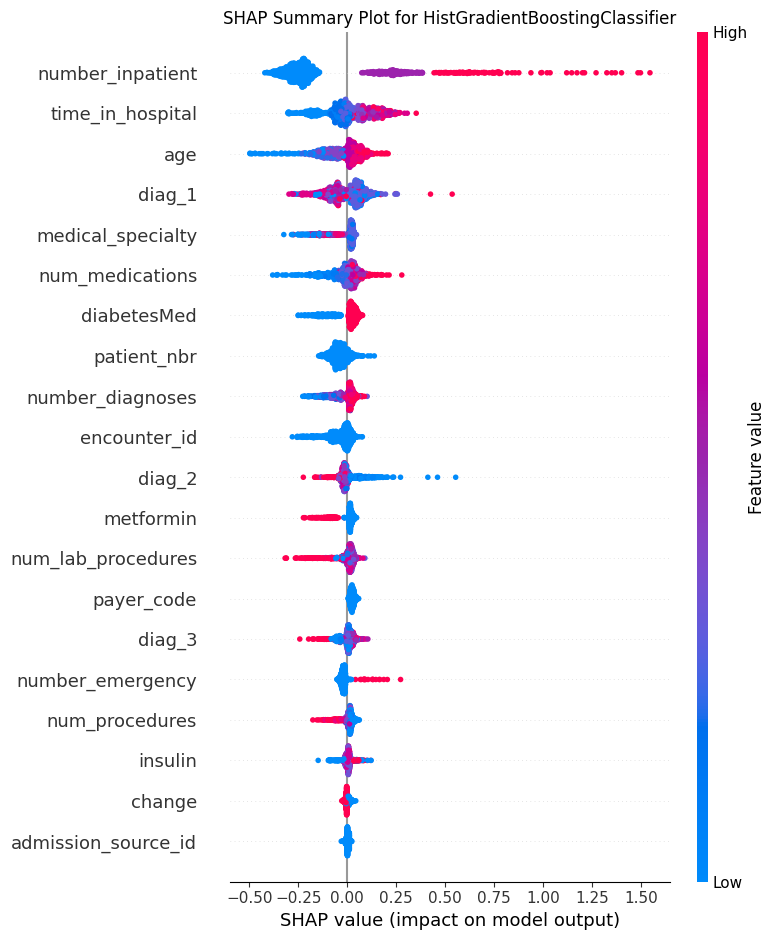

SHAP summary plot generated showing influential variables.


In [70]:
# Map feature names for better interpretability in the plot
# Get feature names from the preprocessor's one-hot encoder and numerical columns
feature_names_num = hgb_preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols)
feature_names_cat = hgb_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(feature_names_num) + list(feature_names_cat)

# Generate the SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_dev_preprocessed[:min(1000, len(X_dev_preprocessed))], feature_names=all_feature_names, show=False)
plt.title('SHAP Summary Plot for HistGradientBoostingClassifier')
plt.tight_layout()
plt.show()

print("SHAP summary plot generated showing influential variables.")

**Reasoning**:
I will generate a SHAP dependence plot for the 'time_in_hospital' feature. This plot will show the effect of this single feature on the model's predictions across the dataset, potentially revealing patterns and interactions. The x-axis will represent the 'time_in_hospital' values, and the y-axis will show the SHAP values for 'time_in_hospital', indicating its impact on the prediction. The plot will be colored by another potentially interacting feature to visualize interaction effects.

<Figure size 1000x600 with 0 Axes>

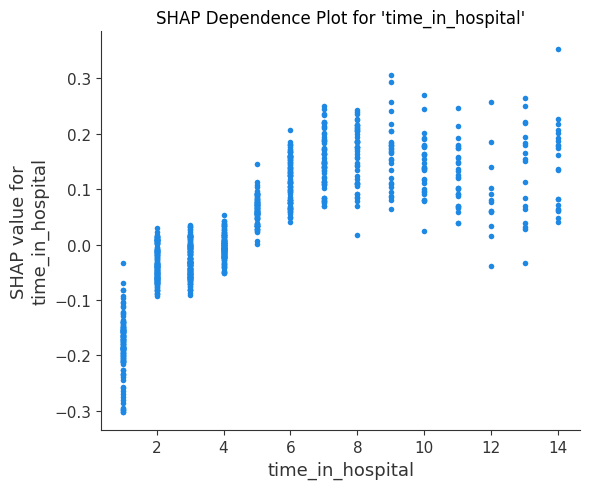

SHAP dependence plot for 'time_in_hospital' generated.


In [73]:
import matplotlib.pyplot as plt
import shap

# Define the subset of X_dev_preprocessed used for SHAP value calculation
X_dev_for_shap_plots = X_dev_preprocessed[:min(1000, len(X_dev_preprocessed))]

# Ensure 'time_in_hospital' is present in all_feature_names
if 'time_in_hospital' in all_feature_names:
    time_in_hospital_feature_idx = all_feature_names.index('time_in_hospital')

    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        ind=time_in_hospital_feature_idx, # Index of the 'time_in_hospital' feature
        shap_values=shap_values,
        features=X_dev_for_shap_plots, # Use the same subset for features
        feature_names=all_feature_names,
        interaction_index=None, # Automatically select the best interaction feature
        show=False
    )
    plt.title("SHAP Dependence Plot for 'time_in_hospital'")
    plt.tight_layout()
    plt.show()
else:
    print("The feature 'time_in_hospital' was not found in the preprocessed feature names. Please check feature names.")

print("SHAP dependence plot for 'time_in_hospital' generated.")

**Reasoning**:
I will generate a SHAP dependence plot for the 'number_inpatient' feature. This plot will show the effect of this single feature on the model's predictions across the dataset, potentially revealing patterns and interactions. The x-axis will represent the 'number_inpatient' values, and the y-axis will show the SHAP values for 'number_inpatient', indicating its impact on the prediction. The plot will be colored by another potentially interacting feature to visualize interaction effects.

<Figure size 1000x600 with 0 Axes>

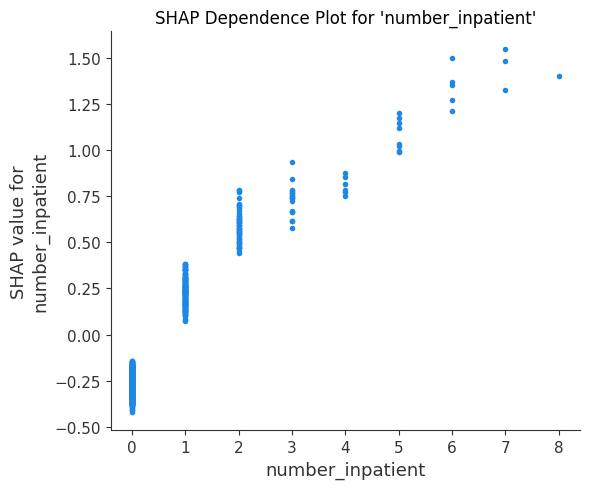

SHAP dependence plot for 'number_inpatient' generated.


In [74]:
import matplotlib.pyplot as plt
import shap

# Define the subset of X_dev_preprocessed used for SHAP value calculation
X_dev_for_shap_plots = X_dev_preprocessed[:min(1000, len(X_dev_preprocessed))]

# Ensure 'number_inpatient' is present in all_feature_names
if 'number_inpatient' in all_feature_names:
    number_inpatient_feature_idx = all_feature_names.index('number_inpatient')

    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        ind=number_inpatient_feature_idx, # Index of the 'number_inpatient' feature
        shap_values=shap_values,
        features=X_dev_for_shap_plots, # Use the same subset for features
        feature_names=all_feature_names,
        interaction_index=None, # Automatically select the best interaction feature
        show=False
    )
    plt.title("SHAP Dependence Plot for 'number_inpatient'")
    plt.tight_layout()
    plt.show()
else:
    print("The feature 'number_inpatient' was not found in the preprocessed feature names. Please check feature names.")

print("SHAP dependence plot for 'number_inpatient' generated.")

**Reasoning**:
I will generate a SHAP dependence plot for the 'age' feature. This plot shows the effect of a single feature on the model's predictions across the dataset, often revealing patterns and interactions. The x-axis will represent the 'age' feature values, and the y-axis will show the SHAP values for 'age', indicating its impact on the prediction. I will color the plot by another potentially interacting feature to visualize interaction effects.